In [1]:
import numpy as np 
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

%matplotlib inline
warnings.filterwarnings('ignore')


In [2]:
raw = pd.read_csv('data/aapl.csv',index_col=0, parse_dates=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2011-10-10 to 2021-10-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


# Feature engineering for AAPL dataset
In this example we want to predict the closing price of Apple stock, for this we will create a numbered of derivative columns in the pandas dataframe (features). Based on the EMH, all information is almost instantly captured by the market so yesterday's closing price should be a good predictor for today's closing price. We also want to take into account the trend of the last 3 days.

In [10]:
data = (pd.DataFrame(raw['Close']).dropna())

data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)
data['Lag4'] = data['Close'].shift(4)
data['Min1Trend'] = np.where(data['Lag1'] - data['Lag2']>0,1,-1)
data['Min2Trend'] = np.where(data['Lag2'] - data['Lag3']>0,1,-1)
data['Min3Trend'] = np.where(data['Lag3'] - data['Lag4']>0,1,-1)
data['Trend_3_day'] = np.where(data['Min1Trend']+data['Min2Trend']+data['Min3Trend']>0,1,-1)

#data.head(5)

traindata = data[['Close','Lag1','Trend_3_day']]
traindata.dropna(inplace=True)
traindata.head(5)

#traindata.to_csv('data/aapl_features.csv')



,Close,Lag1,Trend_3_day
Date,,,
2011-10-11,14.296071,13.886071,-1
2011-10-12,14.363929,14.296071,-1
2011-10-13,14.586786,14.363929,1
2011-10-14,15.071429,14.586786,1
2011-10-17,14.999643,15.071429,1


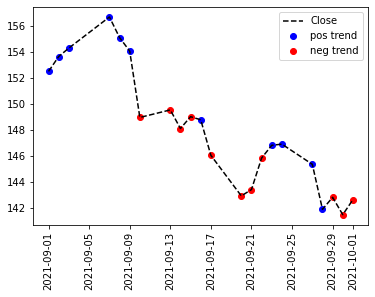

In [22]:
start_date = '2021-9-01'
end_date = '2021-10-01'
if not 'Date' in traindata.columns:
    traindata.insert(loc=0,column='Date',value=pd.to_datetime(traindata.index))


plt.plot('Date','Close','k--',data=(traindata.loc[pd.to_datetime(traindata.Date).between(start_date,end_date)]))

plt.scatter('Date','Close',color='b',label='pos trend',data=(#
    traindata.loc[(traindata.Trend_3_day == 1) & (pd.to_datetime(traindata.Date).between(start_date,end_date))]))

plt.scatter('Date','Close',color='r',label='neg trend',data=(
    traindata.loc[(traindata.Trend_3_day == -1) & (pd.to_datetime(traindata.Date).between(start_date,end_date))]))

plt.legend()
plt.xticks(rotation=90)
plt.show()


# Using linear regression to predict Apple's stock price

We use 2 features Lag1 (Closing price of previous day) and the 3-day trend. Since the dataset contains closing prices from 2011-10-10 to 2021-10-08. (10 years of data), we are going to arbitrarily split in a training data set and a test data after 5 years. (Better methods are available). The Train dataset is used to fit the machine learning algorithm. The Test dataset is used to evaluate the fit of the machine learning model

In [6]:
features = ['Lag1','Trend_3_day']
target= 'Close'
data.info

X_train, X_test = traindata.loc[:'2016-10-10',features] , traindata.loc['2016-10-10':,features]
Y_train, Y_test = traindata.loc[:'2016-10-10',target],traindata.loc['2016-10-10':,target]
#plt.plot(X_train,label='training set')
#plt.plot(X_test,label='Test set',color='orange')
#plt.legend()


In [8]:
regr = linear_model.LinearRegression(fit_intercept=False)

In [9]:
regr.fit(X_train,Y_train)

LinearRegression(fit_intercept=False)

In [12]:
Y_pred = regr.predict(X_test)

The RMSE estimates the deviation of the actual y-values from the regression line.

In [15]:
print('MAE: {0:.2f}}',format(metrics.mean_absolute_error(Y_test,Y_pred)))
print('RMSE: {0:.2f}',format(np.sqrt(mean_squared_error(Y_test,Y_pred))))
print('Variance score: {0:.2f}',format(r2_score(Y_test,Y_pred)))

RMSE: {0:.2f} 1.5373596123754525
Variance score: {0:.2f} 0.9982816542420694


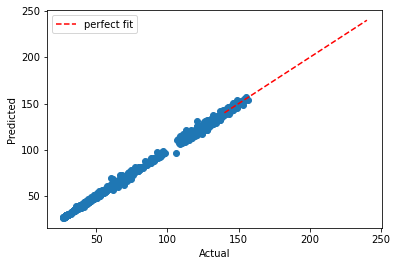

In [16]:
plt.scatter(Y_test,Y_pred)
plt.plot([140,240],[140,240],'r--',label='perfect fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()